In [1]:
! pip install --upgrade sqlalchemy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from typing import List, Optional

from sqlalchemy import create_engine, Column, String, Boolean, DateTime, ForeignKey, Text, Numeric, Enum, Integer
from sqlalchemy.dialects.postgresql import UUID
from sqlalchemy.orm import declarative_base, sessionmaker, relationship, Mapped
from sqlalchemy.orm import mapped_column, column_property
from sqlalchemy.ext.hybrid import hybrid_property

import enum

import datetime
import uuid

import pandas as pd

In [3]:
Base = declarative_base()

def generate_uuid():
    return str(uuid.uuid4())

In [4]:
# Define the User class
class User(Base):
    __tablename__ = "user"

    id = Column(Integer, primary_key=True)
    name = Column(String)
    firstname = Column(String(50))
    lastname = Column(String(50))
    fullname = column_property(firstname + " " + lastname)
    
    addresses = relationship("Address", back_populates="user")

    # Define specific relationships for sent and received transactions
    sent_transactions = relationship(
        "Transaction", foreign_keys="[Transaction.user_id]", back_populates="sender")
    received_transactions = relationship(
        "Transaction", foreign_keys="[Transaction.receiver_id]", back_populates="receiver")

# Define the Address class
class Address(Base):
    __tablename__ = "address"

    id = Column(Integer, primary_key=True)
    user_id = Column(Integer, ForeignKey("user.id"))
    email_address = Column(String)
    address_statistics = Column(Text)

    user = relationship("User", back_populates="addresses")

# Define the TransactionType enum
class TransactionType(enum.Enum):
    CREDIT = 'Credit'
    DEBIT = 'Debit'

# Define the Transaction class
class Transaction(Base):
    __tablename__ = "transaction"

    id = Column(Integer, primary_key=True)
    user_id = Column(Integer, ForeignKey("user.id"))
    receiver_id = Column(Integer, ForeignKey("user.id"))
    amount = Column(Numeric(10, 2))
    transaction_date = Column(DateTime, default=datetime.datetime.utcnow)
    transaction_type = Column(Enum(TransactionType))
    description = Column(Text)

    # Define relationships for sender and receiver
    sender = relationship("User", foreign_keys=[user_id], back_populates="sent_transactions")
    receiver = relationship("User", foreign_keys=[receiver_id], back_populates="received_transactions")


In [5]:
# Create an engine that stores data in the local directory's database file.
engine = create_engine('sqlite:///mydatabase.db')

# Create all tables in the engine.
Base.metadata.create_all(engine)

# Create a session
Session = sessionmaker(bind=engine)
session = Session()

In [6]:
from faker import Faker
import random

fake = Faker()

In [8]:
def insert_users(session, num_users=10000):
    for _ in range(num_users):
        first_name = fake.first_name()
        last_name = fake.last_name()
        full_name = f"{first_name} {last_name}"

        user = User(
            name=full_name,
            firstname=first_name,
            lastname=last_name
        )
        session.add(user)

        # Generate email addresses that are somewhat related to the user's name
        for _ in range(fake.random_int(min=1, max=3)):  # Each user can have 1 to 3 addresses
            # Manually construct an email address using the user's first and last names
            user_email = f"{first_name.lower()}.{last_name.lower()}@example.com"
            address = Address(
                email_address=user_email,
                address_statistics=fake.text(),
                user=user
            )
            session.add(address)

    session.commit()

insert_users(session)



In [9]:
# Query to check if users are inserted
users = session.query(User).all()
print(f"Number of users in the database: {len(users)}")  # Should print the number of users

Number of users in the database: 10000


In [11]:
def insert_transactions(session, num_transactions_per_user=5):
    users = session.query(User).all()
    user_ids = [user.id for user in users]

    for user in users:
        for _ in range(num_transactions_per_user):
            # Randomly select a receiver different from the sender
            receiver_id = random.choice([uid for uid in user_ids if uid != user.id])

            transaction = Transaction(
                user_id=user.id,  # Sender ID
                receiver_id=receiver_id,  # Receiver ID
                amount=random.uniform(10.0, 500.0),
                transaction_date=fake.date_time_between(start_date='-1y', end_date='now'),
                transaction_type=random.choice(list(TransactionType)),
                description=fake.sentence()
            )
            session.add(transaction)

    session.commit()

# Call the function to insert transactions
insert_transactions(session)



In [12]:
def users_addresses_join_unique(session):
    join_data = session.query(
        User.id,  # User ID
        User.name,  # User Name
        User.fullname,  # Full Name
        Address.id,  # Address ID
        Address.email_address,  # Email Address
        Address.address_statistics  # Address Statistics
    ).join(Address, User.id == Address.user_id).all()

    # Convert to list of dictionaries and use a set to track unique user IDs
    join_list = []
    seen_user_ids = set()

    for row in join_data:
        user_id = row[0]  # Accessing User ID

        if user_id not in seen_user_ids:
            seen_user_ids.add(user_id)
            join_list.append({
                "User ID": row[0], 
                "User Name": row[1], 
                "Full Name": row[2],
                "Address ID": row[3], 
                "Email Address": row[4], 
                "Address Statistics": row[5]
            })

    df = pd.DataFrame(join_list)
    return df

df_users_addresses_unique = users_addresses_join_unique(session)
print(df_users_addresses_unique)


      User ID           User Name           Full Name  Address ID  \
0           1    Stephanie Crosby    Stephanie Crosby           1   
1           2        Howard Brown        Howard Brown           2   
2           3        Adrian Lewis        Adrian Lewis           3   
3           4        Jon Williams        Jon Williams           4   
4           5  Jennifer Carpenter  Jennifer Carpenter           5   
...       ...                 ...                 ...         ...   
9995     9996       Aimee Alvarez       Aimee Alvarez       19901   
9996     9997        Joshua Adams        Joshua Adams       19902   
9997     9998    Christian Hunter    Christian Hunter       19904   
9998     9999      Joshua Johnson      Joshua Johnson       19905   
9999    10000   Tiffany Fernandez   Tiffany Fernandez       19906   

                       Email Address  \
0       stephanie.crosby@example.com   
1           howard.brown@example.com   
2           adrian.lewis@example.com   
3          

In [13]:
def users_to_dataframe_unique(session):
    users = session.query(User).distinct().all()
    
    unique_user_data = []
    seen_user_ids = set()

    for user in users:
        if user.id not in seen_user_ids:
            seen_user_ids.add(user.id)
            email_address = user.addresses[0].email_address if user.addresses else None

            unique_user_data.append({
                "User ID": user.id, 
                "Name": user.name, 
                "Full Name": user.fullname,
                "Email Address": email_address
            })

    df = pd.DataFrame(unique_user_data)
    return df

df_unique_users = users_to_dataframe_unique(session)
print(df_unique_users)


      User ID                Name           Full Name  \
0           1    Stephanie Crosby    Stephanie Crosby   
1           2        Howard Brown        Howard Brown   
2           3        Adrian Lewis        Adrian Lewis   
3           4        Jon Williams        Jon Williams   
4           5  Jennifer Carpenter  Jennifer Carpenter   
...       ...                 ...                 ...   
9995     9996       Aimee Alvarez       Aimee Alvarez   
9996     9997        Joshua Adams        Joshua Adams   
9997     9998    Christian Hunter    Christian Hunter   
9998     9999      Joshua Johnson      Joshua Johnson   
9999    10000   Tiffany Fernandez   Tiffany Fernandez   

                       Email Address  
0       stephanie.crosby@example.com  
1           howard.brown@example.com  
2           adrian.lewis@example.com  
3           jon.williams@example.com  
4     jennifer.carpenter@example.com  
...                              ...  
9995       aimee.alvarez@example.com  
999

In [14]:
def address_to_df(session):
    addresses = session.query(Address).all()
    
    address_data = []

    for addr in addresses:
        address_data.append({
            "Address ID": addr.id, 
            "User ID": addr.user_id,
            "Email Address": addr.email_address,
            "Address Statistics": addr.address_statistics
        })

    df = pd.DataFrame(address_data)
    return df

df_addresses = address_to_df(session)
print(df_addresses)

       Address ID  User ID                   Email Address  \
0               1        1    stephanie.crosby@example.com   
1               2        2        howard.brown@example.com   
2               3        3        adrian.lewis@example.com   
3               4        4        jon.williams@example.com   
4               5        5  jennifer.carpenter@example.com   
...           ...      ...                             ...   
19902       19903     9997        joshua.adams@example.com   
19903       19904     9998    christian.hunter@example.com   
19904       19905     9999      joshua.johnson@example.com   
19905       19906    10000   tiffany.fernandez@example.com   
19906       19907    10000   tiffany.fernandez@example.com   

                                      Address Statistics  
0      Wonder family analysis garden half final main....  
1      Both wrong message join future. Ground reflect...  
2      Board effect thing traditional beautiful cup p...  
3      Part quickly

In [15]:
def transactions_to_dataframe(session):
    # Query all transactions
    transactions = session.query(Transaction).all()

    # Check if there are any transactions
    if not transactions:
        print("No transactions found.")
        return pd.DataFrame()  # Return an empty DataFrame

    # Prepare data for DataFrame
    data = []
    for transaction in transactions:
        data.append({
            "Transaction ID": transaction.id,
            "Sender ID": transaction.sender.id if transaction.sender else None,
            "Sender Name": transaction.sender.name if transaction.sender else None,
            "Receiver ID": transaction.receiver.id if transaction.receiver else None,
            "Receiver Name": transaction.receiver.name if transaction.receiver else None,
            "Amount": transaction.amount,
            "Date": transaction.transaction_date,
            "Type": transaction.transaction_type.name,  # Assuming TransactionType is an Enum
            "Description": transaction.description
        })

    # Create a DataFrame from the data
    df = pd.DataFrame(data)
    return df

# Call the function and print the DataFrame
df_transactions = transactions_to_dataframe(session)
print(df_transactions)


       Transaction ID  Sender ID        Sender Name  Receiver ID  \
0                   1          1   Stephanie Crosby         2403   
1                   2          1   Stephanie Crosby          252   
2                   3          1   Stephanie Crosby         8051   
3                   4          1   Stephanie Crosby         1289   
4                   5          1   Stephanie Crosby         8757   
...               ...        ...                ...          ...   
49995           49996      10000  Tiffany Fernandez         1129   
49996           49997      10000  Tiffany Fernandez         9939   
49997           49998      10000  Tiffany Fernandez         4428   
49998           49999      10000  Tiffany Fernandez         8286   
49999           50000      10000  Tiffany Fernandez         8880   

         Receiver Name  Amount                Date    Type  \
0           Caleb Todd  209.57 2023-05-30 17:56:24  CREDIT   
1         Tyler Warner   44.65 2023-07-19 17:45:35   DEBIT 

In [16]:
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)

In [19]:
df_transactions.head(10)

,Transaction ID,Sender ID,Sender Name,Receiver ID,Receiver Name,Amount,Date,Type,Description
0,1,1,Stephanie Crosby,2403,Caleb Todd,209.57,2023-05-30 17:56:24,CREDIT,Vote seek number worker among.
1,2,1,Stephanie Crosby,252,Tyler Warner,44.65,2023-07-19 17:45:35,DEBIT,Tax city some peace.
2,3,1,Stephanie Crosby,8051,Sean Thomas,355.73,2023-10-23 11:36:28,DEBIT,Structure them hundred.
3,4,1,Stephanie Crosby,1289,Charles Fisher,377.18,2023-05-08 13:23:11,DEBIT,Reach social old many interesting campaign peo...
4,5,1,Stephanie Crosby,8757,Stephanie Boyd,311.14,2023-07-31 03:11:44,CREDIT,Research us party surface get society town.
5,6,2,Howard Brown,6109,Lisa Cook,40.81,2023-03-01 00:14:39,DEBIT,Hope respond child economic traditional wait e...
6,7,2,Howard Brown,2612,Jeff Lopez,205.49,2023-06-04 13:34:14,DEBIT,Mother continue material stock close foreign s...
7,8,2,Howard Brown,1569,Bethany Campos,313.24,2023-12-07 06:05:57,DEBIT,Man call rather national organization street s...
8,9,2,Howard Brown,8501,Becky Hansen,42.24,2023-05-20 12:30:16,CREDIT,Cover experience who report kid.
9,10,2,Howard Brown,6882,Makayla Holden,65.62,2023-05-08 22:23:15,CREDIT,Reality talk site wind try our health.


In [54]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [22]:
df = df_transactions.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Transaction ID  50000 non-null  int64         
 1   Sender ID       50000 non-null  int64         
 2   Sender Name     50000 non-null  object        
 3   Receiver ID     50000 non-null  int64         
 4   Receiver Name   50000 non-null  object        
 5   Amount          50000 non-null  object        
 6   Date            50000 non-null  datetime64[ns]
 7   Type            50000 non-null  object        
 8   Description     50000 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 3.4+ MB


In [28]:
# Ensure 'Amount' is of string type
df['Amount'] = df['Amount'].astype(str)

# Step 1: Remove non-numeric characters and convert to numeric
df['Amount'] = df['Amount'].str.replace('[^\d.]', '', regex=True).astype(float)

# Step 2: Use df.describe() to generate summary statistics
description = df.describe()

# Print the summary statistics
print(description)

       Transaction ID     Sender ID   Receiver ID        Amount
count    50000.000000  50000.000000  50000.000000  50000.000000
mean     25000.500000   5000.500000   5001.790760    254.541598
std      14433.901067   2886.780199   2886.951695    141.268536
min          1.000000      1.000000      1.000000     10.000000
25%      12500.750000   2500.750000   2511.750000    131.650000
50%      25000.500000   5000.500000   4997.500000    255.230000
75%      37500.250000   7500.250000   7508.250000    376.200000
max      50000.000000  10000.000000  10000.000000    499.990000


In [38]:
# Define a mapping from category to number
type_to_number = {
    "CREDIT": 1,
    "DEBIT": 2,
    # Add other categories as needed
}

# Apply the mapping to the column
df['Type'] = df['Type'].map(type_to_number)


In [62]:
# Convert 'Date' to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year from 'Date' and create a new column
df['Year'] = df['Date'].dt.year

<AxesSubplot:xlabel='Type', ylabel='count'>

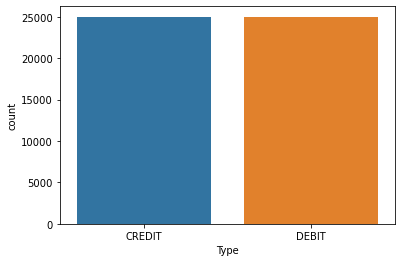

In [30]:
sns.countplot(data=df,x=df['Type'])

In [44]:
# Selecting both 'Amount' and 'Type' columns
X = df[['Amount', 'Type']]

# Normalize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame (optional)
df_scaled = pd.DataFrame(data_scaled, columns=['Amount_Scaled', 'Type_Scaled'])


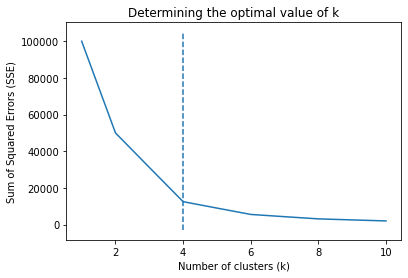

Optimal number of clusters (k): 4


In [45]:
# determining the optimal value of K
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
    
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
optimal_k = kl.elbow

# result visualization
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Determining the optimal value of k')
plt.plot(range(1, 11), sse)
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

print("Optimal number of clusters (k):", optimal_k)

In [51]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_scaled)

# Assign the cluster labels to your original DataFrame
df['Cluster'] = kmeans.labels_

In [52]:
# Analyze the Segments
for i in range(optimal_k):
    print(f"--- Cluster {i} ---")
    segment = df[df['Cluster'] == i]
    print(segment[features].describe())

--- Cluster 0 ---
             Amount     Type
count  12274.000000  12274.0
mean     130.813262      2.0
std       70.028130      0.0
min       10.000000      2.0
25%       71.082500      2.0
50%      130.305000      2.0
75%      191.017500      2.0
max      253.160000      2.0
--- Cluster 1 ---
             Amount     Type
count  12470.000000  12470.0
mean     376.091578      1.0
std       70.957689      0.0
min      253.740000      1.0
25%      315.047500      1.0
50%      375.520000      1.0
75%      436.797500      1.0
max      499.990000      1.0
--- Cluster 2 ---
             Amount     Type
count  12541.000000  12541.0
mean     131.817131      1.0
std       70.485914      0.0
min       10.030000      1.0
25%       70.920000      1.0
50%      131.450000      1.0
75%      193.870000      1.0
max      253.720000      1.0
--- Cluster 3 ---
             Amount     Type
count  12715.000000  12715.0
mean     375.815751      2.0
std       71.240559      0.0
min      253.170000      2.0


In [66]:
df

,Transaction ID,Sender ID,Sender Name,Receiver ID,Receiver Name,Amount,Date,Type,Description,Amount_Scaled,Cluster,Year
0,1,1,Stephanie Crosby,2403,Caleb Todd,209.57,2023-05-30 17:56:24,1,Vote seek number worker among.,-0.318344,2,2023
1,2,1,Stephanie Crosby,252,Tyler Warner,44.65,2023-07-19 17:45:35,2,Tax city some peace.,-1.485778,0,2023
2,3,1,Stephanie Crosby,8051,Sean Thomas,355.73,2023-10-23 11:36:28,2,Structure them hundred.,0.716291,3,2023
3,4,1,Stephanie Crosby,1289,Charles Fisher,377.18,2023-05-08 13:23:11,2,Reach social old many interesting campaign peo...,0.868131,3,2023
4,5,1,Stephanie Crosby,8757,Stephanie Boyd,311.14,2023-07-31 03:11:44,1,Research us party surface get society town.,0.400648,1,2023
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,10000,Tiffany Fernandez,1129,Tim Andrews,199.74,2023-01-18 21:40:36,2,But charge toward threat sea future big.,-0.387929,0,2023
49996,49997,10000,Tiffany Fernandez,9939,Tony Green,394.68,2023-09-14 05:03:48,2,Stuff sing race speak many.,0.992010,3,2023
49997,49998,10000,Tiffany Fernandez,4428,Emily Cooke,80.12,2023-04-09 19:20:21,1,Those according detail begin.,-1.234693,2,2023
49998,49999,10000,Tiffany Fernandez,8286,Sarah Young,479.64,2023-06-04 03:50:08,1,Reason why middle worker ready then.,1.593424,1,2023


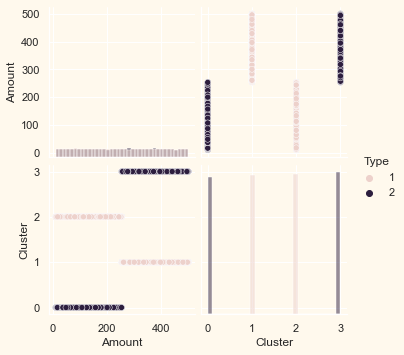

In [75]:
# Create the pair plot with a built-in palette
sns.pairplot(df[['Amount', 'Cluster','Type']], hue='Type', diag_kind='hist')
plt.show()
